# Análise exploratória dos dados

Importando bibliotecas e armazenando funções

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
# import optuna
from time import time
import matplotlib.dates as mdates
sns.set_theme()

def resume_df(df):
  df.reset_index(drop=True,inplace=True)
  df_aux = pd.DataFrame(index=df.columns)
  df_aux["Tipo"] = df.dtypes
  df_aux["Valores Ausentes [%]"] = round(100*df.isna().sum()/df.shape[0],2)
  df_aux["Valores Únicos"] = df.nunique()
  df_aux["Valores Únicos [%]"] = round(100*df_aux["Valores Únicos"]/df.shape[0],2)
  return df_aux

def estatisticas_df(df):
  df_aux = pd.DataFrame(index=df.columns)
  df_aux["Mínimo"] = df.apply(np.min, axis=0)
  df_aux["Máximo"] = df.apply(np.max, axis=0)
  df_aux["Mediana"] = df.apply(np.median, axis=0)
  df_aux["Média"] = df.apply(np.mean, axis=0)
  df_aux["Desvio Padrão"] = df.apply(np.std, axis=0)
  df_aux["Obliquidade"] = df.apply(skew, axis=0)
  df_aux["Curtose"] = df.apply(kurtosis, axis=0)
  df_aux["Núm. de Outliers"] = df.apply(existem_outliers, axis=0)
  return df_aux

def existem_outliers(s) -> int:
    q1 = np.quantile(s,.25)
    q3 = np.quantile(s,.75)
    iiq = q3 - q1
    ls = q3 + 1.5*iiq
    li = q1 - 1.5*iiq
    return len(s[(s>ls)|(s<li)])

def marca_outliers(s) -> bool:
    q1 = np.quantile(s,.25)
    q3 = np.quantile(s,.75)
    iiq = q3 - q1
    ls = q3 + 1.5*iiq
    li = q1 - 1.5*iiq
    return ~((s<li)|(s>ls))

Leitura da base de dados limpa e pré-processamento da coluna 'timestamp'

In [2]:
df = pd.read_csv("1_ano_dados_data_center_limpa.csv")
df.index = pd.to_datetime(df.timestamp)
df.drop(columns=["timestamp"], inplace=True)

Verificando a presença de valores ausentes e valores únicos. 

In [3]:
resume_df(df)

,Tipo,Valores Ausentes [%],Valores Únicos,Valores Únicos [%]
hora_dia,int64,0.0,24,0.27
dia_semana,int64,0.0,7,0.08
requisicoes,int64,0.0,8246,93.88
trafego_MBps,float64,0.0,8784,100.00
usuarios_ativos,int64,0.0,8440,96.08
temp_ambiente_C,float64,0.0,8784,100.00
uso_cpu_%,float64,0.0,8784,100.00
uso_ram_%,float64,0.0,8784,100.00
demanda_energia_kW,float64,0.0,8784,100.00
pressao_resfriamento_bar,float64,0.0,8784,100.00


## Análise Exploratória dos Dados

A análise exploratória de dados (AED) desempenha um papel crucial no processo de análise de dados e modelagem estatística. Ela envolve técnicas para examinar, resumir e visualizar os dados de forma a extrair insights preliminares e compreender melhor suas características. Aqui estão alguns pontos que destacam a importância da AED:

1. **Identificação de Padrões e Tendências:** A AED permite identificar padrões ocultos nos dados que podem influenciar diretamente a modelagem e a interpretação dos resultados.

2. **Detecção de Outliers e Dados Anômalos:** Ao explorar visualmente os dados, é possível identificar valores extremos (outliers) e dados anômalos que podem distorcer análises posteriores.

3. **Seleção e Engenharia de Features:** A análise exploratória ajuda na seleção e na engenharia de features relevantes para o modelo, melhorando a precisão e o desempenho preditivo.

4. **Validação de Suposições:** Permite validar suposições iniciais sobre os dados, como distribuições, correlações entre variáveis e relações causa-efeito.

5. **Preparação de Dados para Modelagem:** Ajuda na limpeza e no pré-processamento dos dados, incluindo tratamento de dados ausentes, normalização e transformações necessárias.

6. **Comunicação de Resultados:** Gráficos e visualizações criados durante a AED são úteis para comunicar descobertas complexas de maneira clara e compreensível.

A análise exploratória de dados é fundamental para garantir a qualidade e a confiabilidade das análises subsequentes, proporcionando uma base sólida para a tomada de decisões informadas em projetos de ciência de dados e análise estatística.

In [4]:
# Verificando tamanho da base de dados

print(f"Temos {df.shape[0]} linhas e {df.shape[1]} colunas na base de dados atual.")

Temos 8784 linhas e 11 colunas na base de dados atual.


In [5]:
print(f"Temos {df.isna().sum().sum()} dados nulos na base de dados após limpeza.")

Temos 0 dados nulos na base de dados após limpeza.


# Curtose e Obliquidade

## Curtose

A **curtose** é uma medida estatística empregada para caracterizar a forma de uma distribuição de dados, com ênfase em suas caudas. Em termos gerais, descreve o grau de concentração de valores em torno da média e a frequência de ocorrência de valores extremos (outliers). Uma distribuição com alta curtose tende a apresentar caudas pesadas, enquanto distribuições com baixa curtose apresentam caudas mais leves (DECARLO, 1997; GROENEVELD; MEEDEN, 1984).

### Definição Formal
Do ponto de vista matemático, a curtose corresponde ao **momento central de quarta ordem**, normalizado pela variância elevada ao quadrado. Para uma variável aleatória $X$, com média $\mu$ e desvio padrão $\sigma$, a curtose é definida como:

$$
K = \frac{E[(X - \mu)^4]}{\sigma^4}
$$

Em muitos contextos, utiliza-se a **curtose excessiva**, obtida por $K - 3$, de forma que a distribuição normal apresente valor igual a zero.

### Interpretação
- **Curtose = 0**: comportamento semelhante ao da distribuição normal (*mesocúrtica*).  
- **Curtose > 0**: distribuição **leptocúrtica**, caracterizada por caudas pesadas e maior incidência de valores extremos.  
- **Curtose < 0**: distribuição **platicúrtica**, marcada por caudas mais leves e menor ocorrência de outliers.  

### Aplicações
A curtose possui relevância em diversos campos:  
- **Estatística aplicada**: na avaliação da adequação de modelos probabilísticos.  
- **Econometria e finanças**: na análise de risco e na detecção de volatilidade em séries temporais.  
- **Ciência de dados e machine learning**: na verificação da distribuição de resíduos em modelos preditivos, prevenindo que valores extremos distorçam os resultados.  

---

## Obliquidade (Skewness)

A **obliquidade**, ou *skewness*, é uma medida que descreve a assimetria de uma distribuição em relação ao seu valor central. Enquanto a curtose foca nas caudas, a obliquidade indica a direção e intensidade do desvio da simetria, sendo uma estatística crucial para caracterizar a forma da distribuição (GROENEVELD; MEEDEN, 1984).

### Definição Formal
A obliquidade é definida pelo **momento central de terceira ordem**, normalizado pelo cubo do desvio padrão:

$$
S = \frac{E[(X - \mu)^3]}{\sigma^3}
$$

### Interpretação
- **Skewness = 0**: distribuição simétrica, análoga à normal.  
- **Skewness > 0**: distribuição **assimétrica à direita**, com cauda alongada à direita.  
- **Skewness < 0**: distribuição **assimétrica à esquerda**, com cauda alongada à esquerda.  

### Aplicações
A obliquidade apresenta ampla aplicação:  
- **Análise estatística**: identificação da direção da assimetria para seleção de modelos adequados.  
- **Finanças**: estudo de retornos de ativos, frequentemente caracterizados por distribuições assimétricas.  
- **Ciência de dados e machine learning**: ajuste de modelos que pressupõem normalidade nos resíduos, garantindo maior robustez preditiva.  

---


### Estatísticas descritivas e contagem de outliers

In [6]:
X = df.select_dtypes(include=(np.number))

lista_cat = []
for c in X.columns:
    if len(X[c].value_counts().values) <= 2:
        lista_cat.append(c)

X_nocat = X.loc[:,~X.columns.isin(lista_cat)].copy()

df_estatisticas = estatisticas_df(X_nocat)
pd.options.display.float_format = '{:.5f}'.format
df_estatisticas

,Mínimo,Máximo,Mediana,Média,Desvio Padrão,Obliquidade,Curtose,Núm. de Outliers
hora_dia,0.00000,23.00000,11.50000,11.50000,6.92219,0.00000,-1.20417,0
dia_semana,0.00000,6.00000,3.00000,2.99727,1.99521,0.00376,-1.24261,0
requisicoes,11670.00000,274682.00000,45566.50000,64649.38525,36190.55093,0.78735,0.16285,35
trafego_MBps,-4.07070,73.94158,21.00142,24.25991,13.34636,0.41957,-0.68556,7
usuarios_ativos,43828.00000,481049.00000,93016.00000,124573.78199,61804.80527,0.67684,-0.34783,23
temp_ambiente_C,13.82882,33.98954,22.13317,22.08863,3.27717,0.03744,-0.78703,5
uso_cpu_%,31.80604,77.74003,50.58103,50.80022,5.45201,0.46049,1.12880,162
uso_ram_%,30.94604,65.45291,45.48925,45.61526,4.24118,0.29393,0.64856,141
demanda_energia_kW,430.58300,657.89975,528.00245,528.61369,26.64841,0.35360,0.92143,148
pressao_resfriamento_bar,1.61229,2.06947,1.78253,1.78523,0.05881,0.49931,0.73647,139


### Boxplot dos atributos

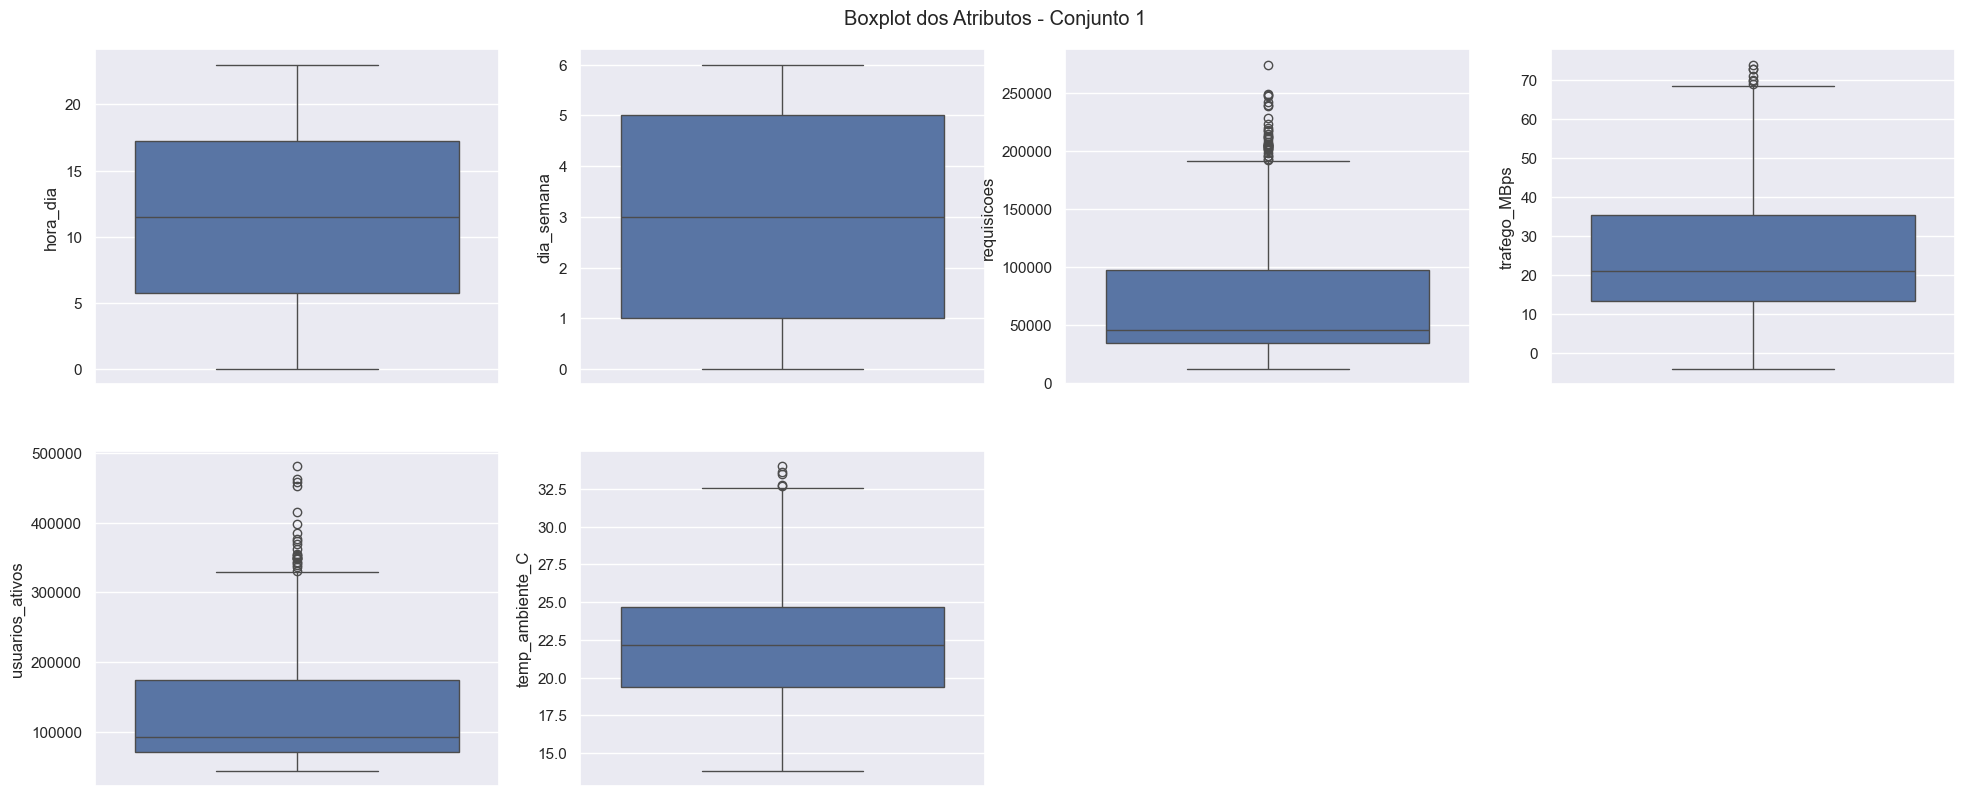

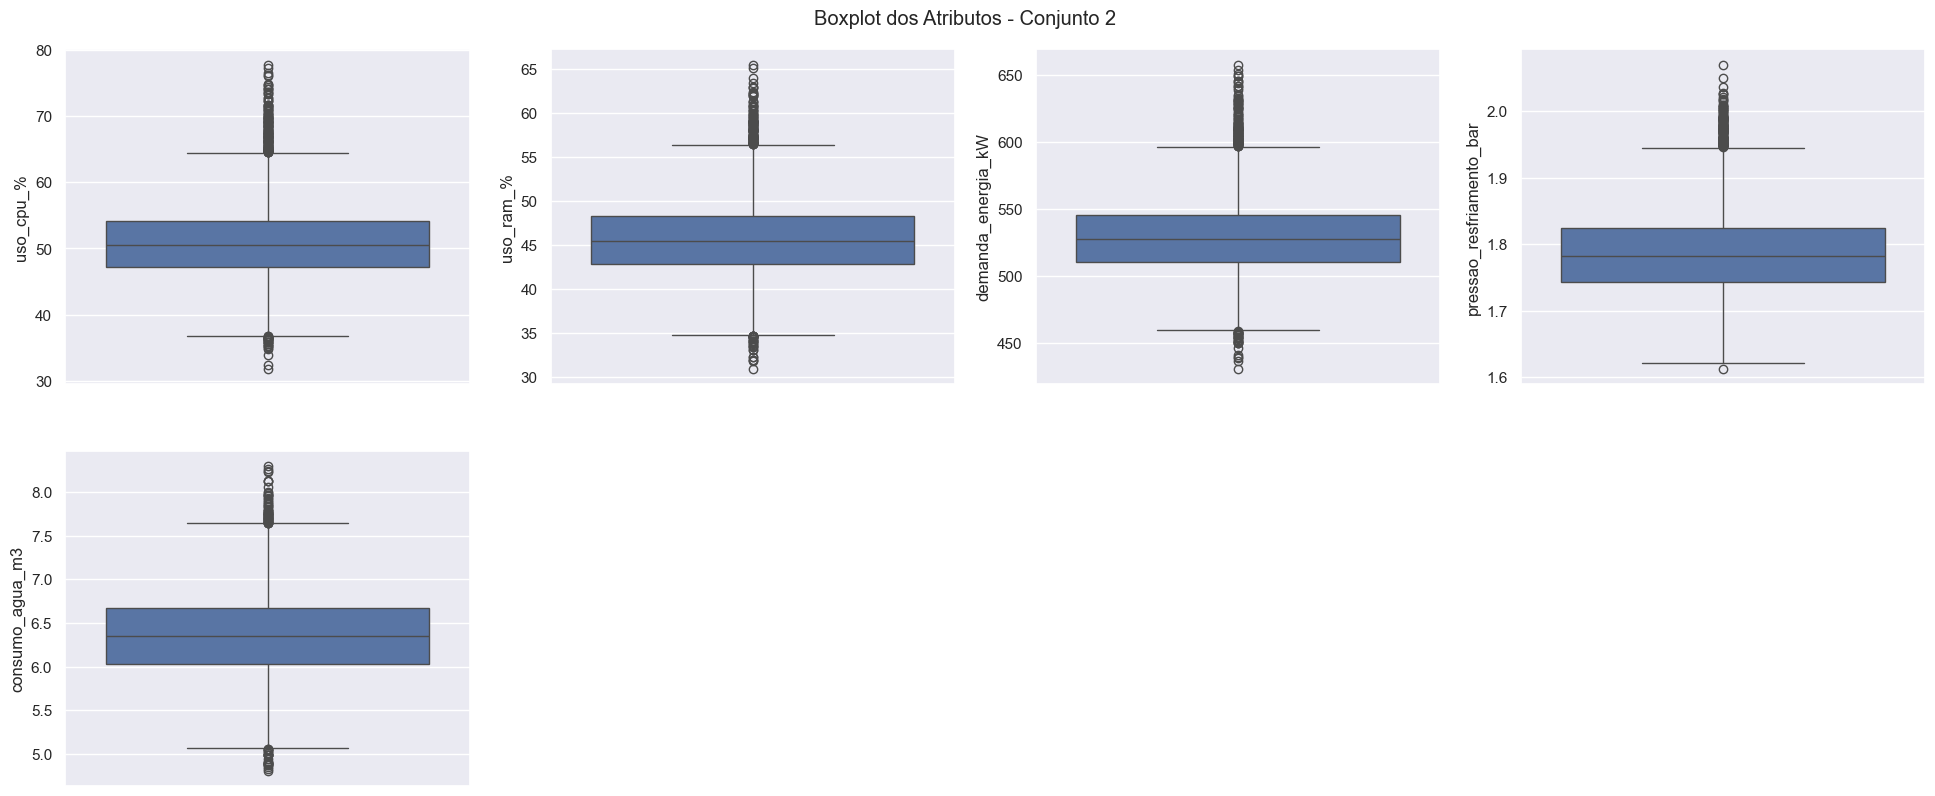

In [7]:
conjuntos = np.array_split(X_nocat.columns.to_numpy(),2)

for j in range(len(conjuntos)):
  f = plt.figure(j)
  n_columns = len(conjuntos[j])
  pos = range(1,n_columns+1)
  f.set_size_inches(24, 20)
  f.tight_layout(pad=1.5)
  f.suptitle(f'Boxplot dos Atributos - Conjunto {j+1}', y=0.90)
  for i, column in zip(range(n_columns), conjuntos[j]):
    axx = f.add_subplot(4,4,pos[i])
    # axx.set_xlabel("Classe")
    # sns.boxplot(y=column, x='label', data=df, ax=axx)
    sns.boxplot(y=column, data=df, ax=axx)

### Histogramas dos atributos

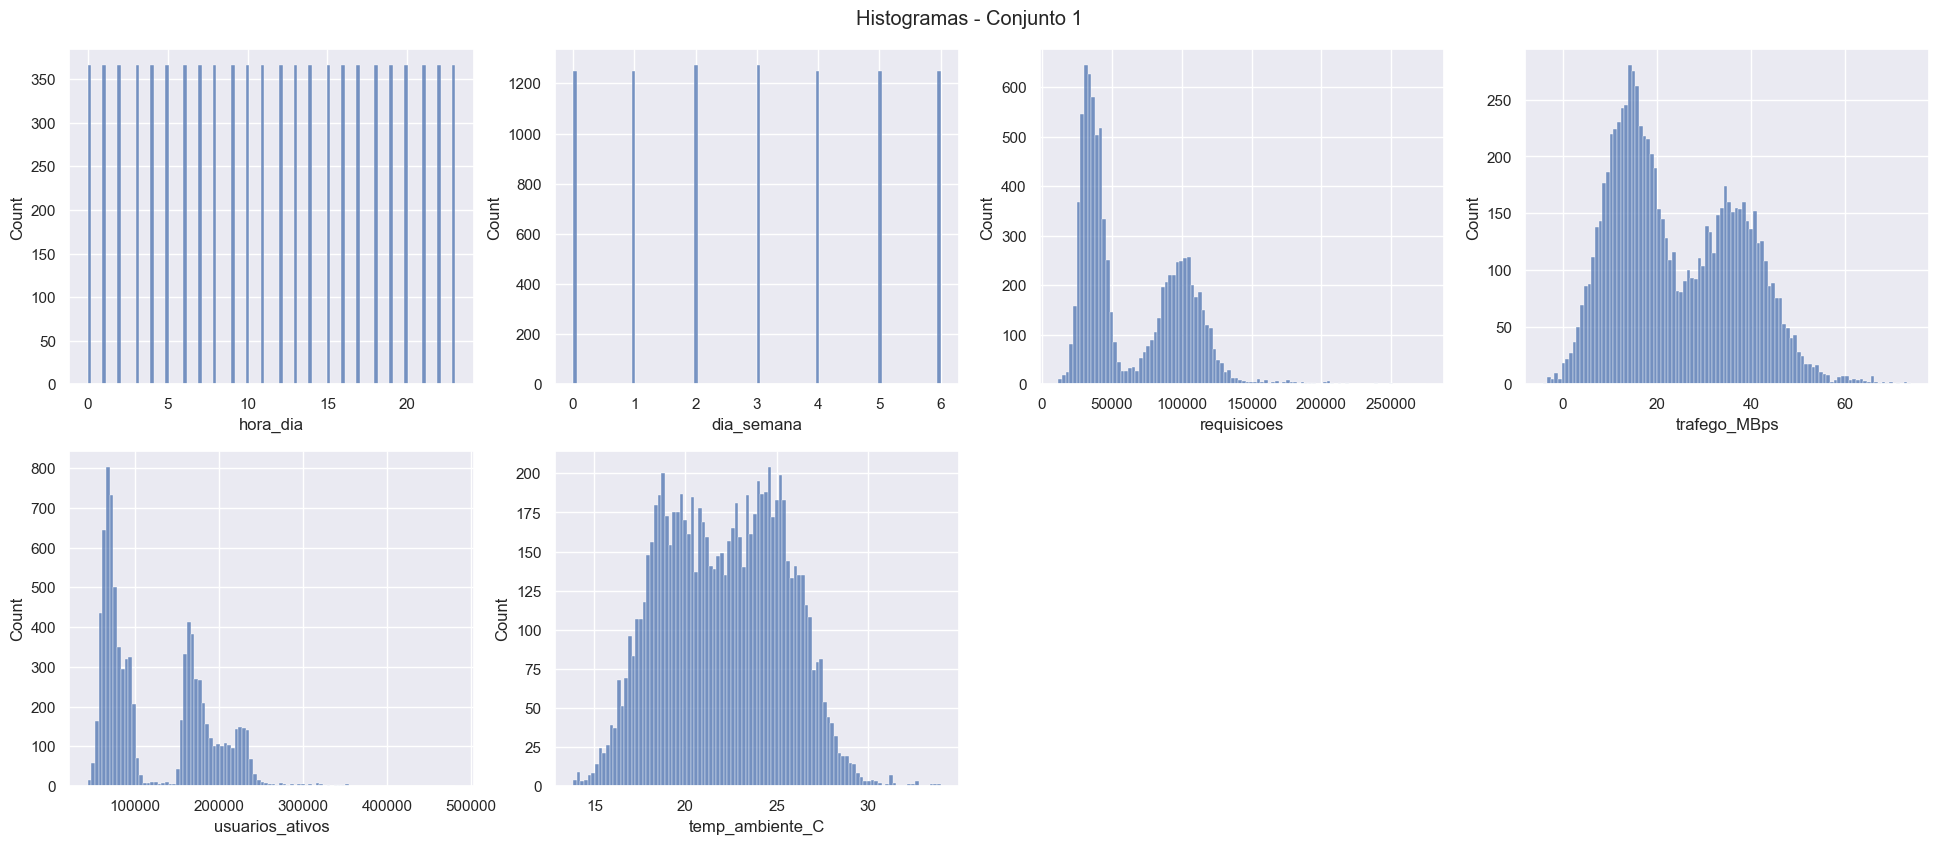

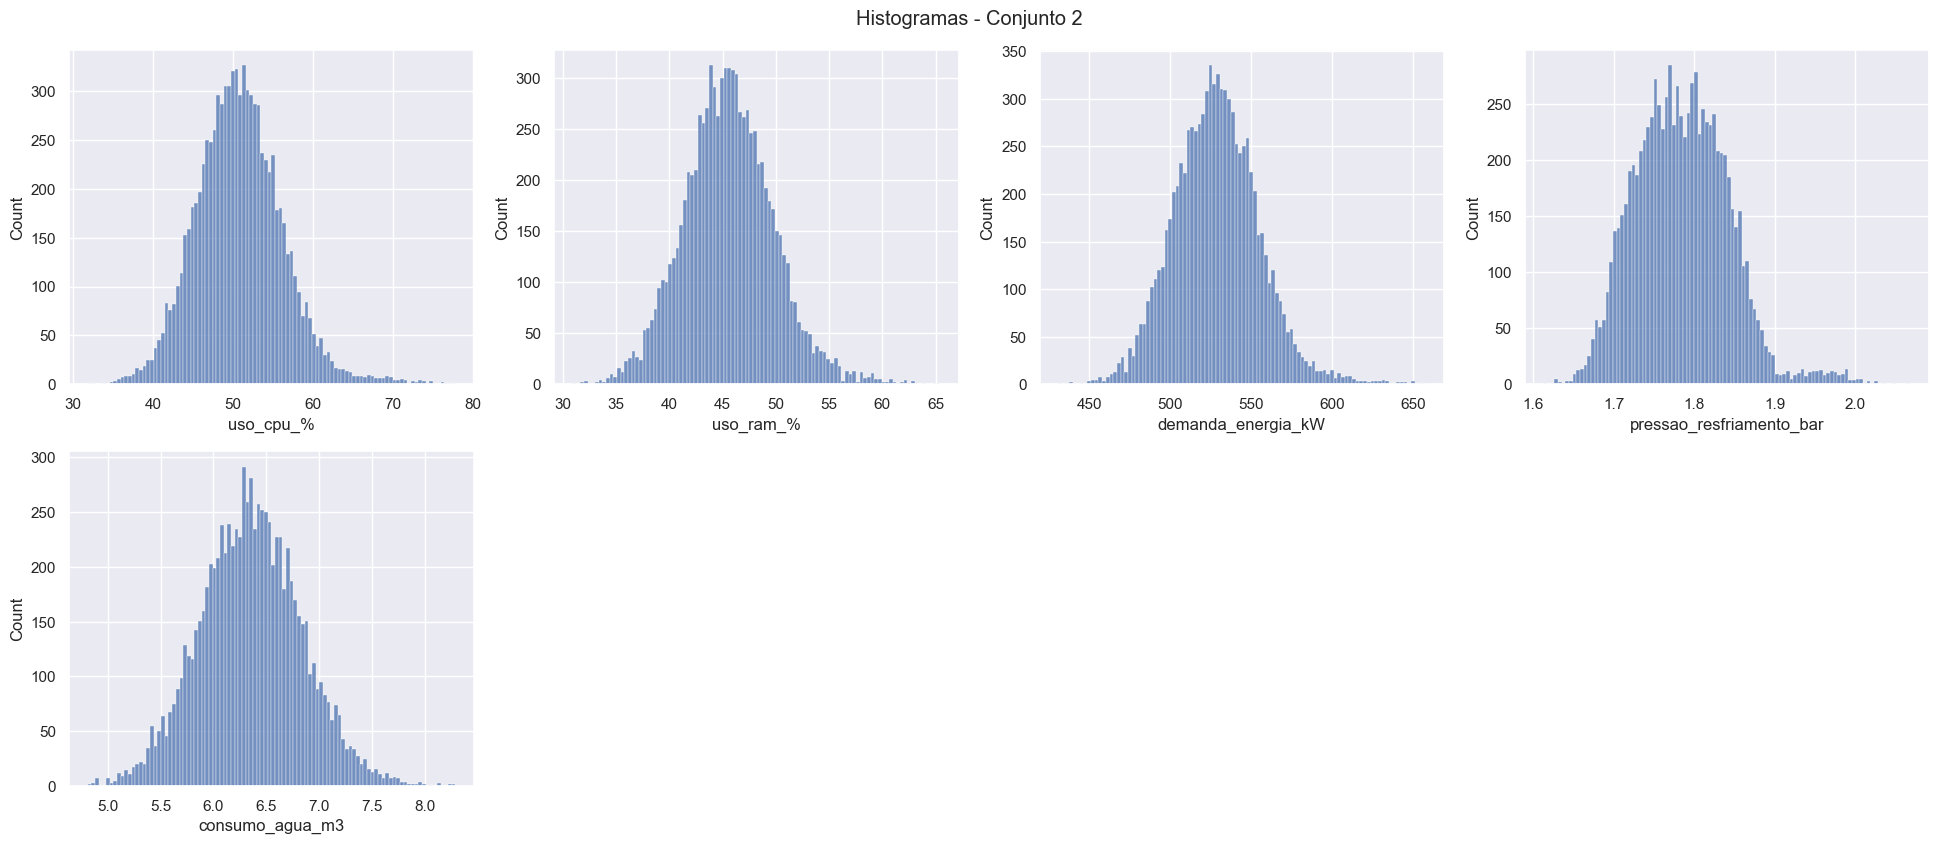

In [8]:
conjuntos = np.array_split(X_nocat.columns.to_numpy(),2)

for j in range(len(conjuntos)):
  f = plt.figure(j)
  n_columns = len(conjuntos[j])
  pos = range(1,n_columns+1)
  f.set_size_inches(24, 20)
  f.tight_layout(pad=1.5)
  f.suptitle(f'Histogramas - Conjunto {j+1}', y=0.90)
  for i, column in zip(range(n_columns), conjuntos[j]):
    axx = f.add_subplot(4,4,pos[i])
    # axx.set_ylabel("Frequência")
    sns.histplot(data=df, x=column, multiple="layer", ax=axx, bins=100)

### Análise Estatística e Visualização de Série Temporal de Requisições

#### Estatísticas Descritivas

A análise inicia com o cálculo de estatísticas descritivas fundamentais para a variável de requisições, seguindo metodologias estabelecidas na literatura de análise exploratória de dados (Tukey, 1977). Foram obtidas quatro medidas essenciais: média aritmética, desvio padrão, valor mínimo e valor máximo. Estas métricas permitem uma caracterização inicial da distribuição dos dados, seguindo a abordagem de análise univariada proposta por Hair, Black e Babin (2019) para compreensão preliminar do comportamento da variável.

A média representa a tendência central dos dados, enquanto o desvio padrão quantifica a variabilidade em torno desta média. Os valores mínimo e máximo delimitam a amplitude total da distribuição, proporcionando insights sobre a dispersão dos dados.

#### Estatísticas Móveis (Rolling Statistics)

Foram calculadas estatísticas móveis utilizando uma janela temporal de 24 horas, técnica amplamente utilizada na análise de séries temporais (Box, Jenkins & Reinsel, 2015). A média móvel de 24 horas permite identificar tendências de longo prazo e suavizar flutuações de alta frequência, enquanto o desvio padrão móvel possibilita a análise da volatilidade e estabilidade do sistema ao longo do tempo.

Esta abordagem segue a metodologia de suavização exponencial proposta por Brown (2004), particularmente útil para detectar padrões sazonais e tendências em dados temporais.

#### Visualização de Série Temporal

A visualização foi construída utilizando a biblioteca Matplotlib, seguindo princípios de visualização científica estabelecidos por Tufte (2001). O gráfico apresenta múltiplas camadas de informação:

- **Série original**: Representada em cinza com transparência, mostra os valores instantâneos de requisições
- **Média móvel**: Linha azul contínua que representa a tendência de longo prazo
- **Banda de variabilidade**: Área sombreada que indica o intervalo de ±1 desvio padrão em torno da média móvel

A seleção dos últimos 1000 pontos para visualização segue a recomendação de Cleveland (1993) para manter a legibilidade temporal enquanto preserva informações relevantes sobre o comportamento recente do sistema. A formatação do eixo temporal inclui dia, mês, hora e minuto, seguindo as diretrizes de visualização de séries temporais de Few (2004).

Volume de Requisições – Média: 64649.4 | Desvio padrão: 36192.6 | Mín: 11670.0 | Máx: 274682.0


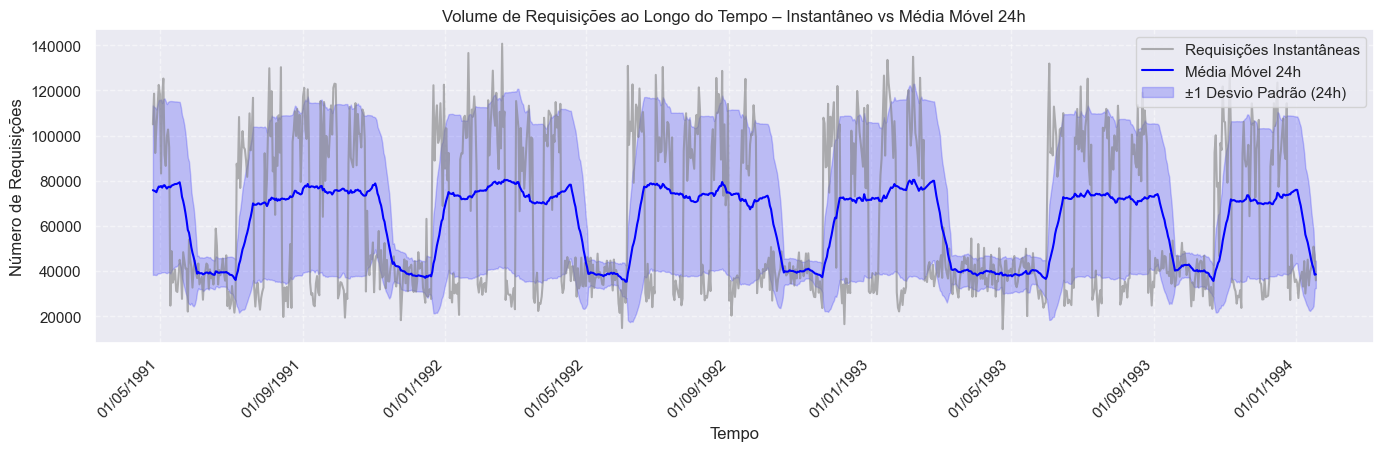

In [9]:
# Estatísticas descritivas: Obtemos a média, desvio padrão, valor mínimo e máximo das requisições e transações PIX
mean_requisicoes = df['requisicoes'].mean()  # Média de requisições
std_requisicoes  = df['requisicoes'].std()   # Desvio padrão das requisições
min_requisicoes  = df['requisicoes'].min()   # Valor mínimo de requisições
max_requisicoes  = df['requisicoes'].max()   # Valor máximo de requisições

# Imprimindo os resultados das estatísticas descritivas para entender melhor o volume de requisições e transações
print(f"Volume de Requisições – Média: {mean_requisicoes:.1f} | Desvio padrão: {std_requisicoes:.1f} | Mín: {min_requisicoes:.1f} | Máx: {max_requisicoes:.1f}")

# Rolling statistics: Calculamos a média móvel e o desvio padrão para requisições e transações PIX ao longo das últimas 24 horas
df['requisicoes_ma_24h'] = df['requisicoes'].rolling(window=24).mean()  # Média móvel de 24h para requisições
df['requisicoes_std_24h'] = df['requisicoes'].rolling(window=24).std()   # Desvio padrão de 24h para requisições

df_last_1000 = df.tail(1000)

plt.figure(figsize=(14, 8))

# Subplot 1: Volume de requisições ao longo do tempo
plt.subplot(2, 1, 1)

plt.plot(df_last_1000.index, df_last_1000['requisicoes'],
         color='gray', alpha=0.6, label='Requisições Instantâneas')

plt.plot(df_last_1000.index, df_last_1000['requisicoes_ma_24h'],
         color='blue', label='Média Móvel 24h')

plt.fill_between(df_last_1000.index,
                 df_last_1000['requisicoes_ma_24h'] - df_last_1000['requisicoes_std_24h'],
                 df_last_1000['requisicoes_ma_24h'] + df_last_1000['requisicoes_std_24h'],
                 color='blue', alpha=0.2, label='±1 Desvio Padrão (24h)')

# Título e eixos
plt.title('Volume de Requisições ao Longo do Tempo – Instantâneo vs Média Móvel 24h')
plt.xlabel('Tempo')
plt.ylabel('Número de Requisições')

# Formatando o eixo X com menos poluição
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # espaçamento automático
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))

plt.xticks(rotation=45, ha='right')  # inclinação para não sobrepor
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [10]:
df_last_1000.index

RangeIndex(start=7784, stop=8784, step=1)

### Interpretação dos Resultados - média e variabilidade das requisições:

As médias de requisições indicam um volume estável de atividades bancárias. No entanto, o desvio padrão, refletindo a variabilidade dos dados, sugere que há flutuações regulares nos volumes durante o período analisado. Essas flutuações podem estar associadas a picos de atividade em horários de maior tráfego, como horários comerciais, feriados ou eventos específicos.

A média móvel de 24 horas ajuda a identificar tendências de curto e longo prazo no volume de requisições. Se houver uma inclinação consistente na curva (aumento ou diminuição), isso pode indicar uma mudança gradual no comportamento do usuário, como aumento de transações em resposta a campanhas de marketing, novos produtos financeiros ou mudanças econômicas.

As áreas sombreadas indicam o intervalo de variação esperada para as requisições, com base no desvio padrão. Oscilações fora dessa banda, ou picos atípicos, podem ser indicativos de anomalias ou eventos críticos, como:

- Falhas em sistemas que resultam em transações repetidas ou erradas.

- Eventos externos, como falhas em outros canais de pagamento (por exemplo, falhas em outros bancos ou sistemas de pagamento).

# Referências Bibliográficas

1. BARROSO, L. A.; CLOUDŚ, U.; HÖLZLE, U. *The Datacenter as a Computer: Designing Warehouse-Scale Machines*. Synthesis Lectures on Computer Architecture, 2018.  

2. BOX, G. E. P.; JENKINS, G. M.; REINSEL, G. C. *Time Series Analysis: Forecasting and Control*. 5. ed. Hoboken: John Wiley & Sons, 2015.  

3. BROWN, R. G. *Smoothing, Forecasting and Prediction of Discrete Time Series*. Mineola: Dover Publications, 2004.  

4. CLEVELAND, W. S. *Visualizing Data*. Summit: Hobart Press, 1993.  

5. DAYARATHNA, M.; WEN, Y.; FAN, R. *Data Center Energy Consumption Modeling: A Survey*. IEEE Communications Surveys & Tutorials, 2016.  

6. DECARLO, L. T. On the Meaning and Use of Kurtosis. *Psychological Methods*, 1997.  

7. FEW, S. *Show Me the Numbers: Designing Tables and Graphs to Enlighten*. Burlingame: Analytics Press, 2004.  

8. GROENEVELD, R. A.; MEEDEN, G. Measuring Skewness and Kurtosis. *Journal of the Royal Statistical Society: Series D (The Statistician)*, 1984.  

9. HAIR, J. F.; BLACK, W. C.; BABIN, B. J. *Multivariate Data Analysis*. 8. ed. Andover: Cengage Learning, 2019.  

10. PENG, R. D. *Exploratory Data Analysis with R*. Cham: Springer, 2016.  

11. TUKEY, J. W. *Exploratory Data Analysis*. Reading: Addison-Wesley, 1977.  

12. TUFTE, E. R. *The Visual Display of Quantitative Information*. 2. ed. Cheshire: Graphics Press, 2001.  

13. WICKHAM, H.; GROLEMUND, G. *R for Data Science: Import, Tidy, Transform, Visualize, and Model Data*. Sebastopol: O’Reilly Media, 2016.  
  
